# Discussion 5: overparametrization

In this discussion we are going to build up to problem 4 "Linear Regression in Overparameterized Regime" of HW 5. We will look at a problem of learning a function on [-1,1], but with more features than data points. As it turns out, **the shape of the spectrum of the covariance can sometimes help prevent overfitting** and cope with noise even without regularization! 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interactive
import ipywidgets as widgets
from ipywidgets import fixed

# Import various helpful functions
from dis5_helpers import *

### Introduction

We are going to deal with linear regression in the regime when we have more features than samples. In this regime **columns of matrix ${\bf X}$ must be linearly dependent.** If, apart from that, ${\bf X}$ has independent rows, then for any ${\bf y}$  **there exists infinitely many values of parameters ${\bf \theta}$  for which ${\bf X\theta = y}$.** In such situation it doesn't make sense to solve least squares, and we consider the minimum-norm interpolating solution:
$$
\min\|{\bf \theta}\|_2^2 \text{ s.t. } {\bf X\theta = y}.
$$

In this particular problem we are going to stick to the following example: we are learning a function $f$ on $[0,1]$. Our training data forms an evenly sampled grid on this segment, and our test data comes from the uniform distribution on it. We use **weighted fourier features for learning**, and our goal is to see how the weights of the features influence the performance (note that since our features are orthogonal w.r.t. the test distribution, the weights are exactly the eigenvalues of the covariance matrix).

In part **a** we will look at those features and how they interact with our choice of training data. In part **b** we will see how introducing weights of those features influences our prediction. In part **c** we will look at the results that you will show in problem 4 of HW5 and compare them to numerical sumulations. Part **d** shows why the "decay of weights" that we chose is not unusual in practice, and in part **e** we start proving theoretical results.

### Part a

Let's look at our features, and how they work differently with the training and test data. The following cell plots the feature with number "feature index". Blue dots correspond to the value of that feature on training data, and green - on the test data. 

**Do the following:**
1. **Set "plot test data" to true. Observe different features that we use.**
2. **Now set "plot test data" to false. Compare feature 0 with feature 44. What do you see? What about features 1 and 45?**
3. **Repeat the previous part but set "plot test data" to true. Can you explain what happens and why?**

In [2]:
n_train = 11
n_test = 10000
n_features = 55
x_train = generate_x(x_type='grid', n=n_train)
phi_train = featurize_fourier(x_train, n_features)


x_test = generate_x(x_type = 'uniform_random', n=n_test)
phi_test = featurize_fourier(x_test, n_features)

def plot_feature(feature_index, plot_train, plot_test):
    plt.xlabel('coeffs')
    plt.xlim(-1,1)
    plt.ylim(-1.1, 1.1)
    plt.ylabel('feature(k)')
    if plot_train:
        plt.scatter(x_train, phi_train[:, feature_index], c='b', label='feature in training points')
    if plot_test:
        plt.scatter(x_test, phi_test[:, feature_index], c='g', s=5, label='feature in test points')
    plt.legend()
interactive_plot = interactive(plot_feature,
                               feature_index=generate_int_widget('feature index', 0, 0, n_features-1),
                               plot_train=fixed(True),
                               plot_test=generate_bool_widget('plot test data'))
    
interactive_plot  

interactive(children=(IntSlider(value=0, continuous_update=False, description='feature index:', max=54), Radio…

We see that features that are **different on the test data**, are **exactly the same on the training data!** This peculiar property makes it much easier to analyze the procedure: instead of arbitrary linear dependence of columns, we simply have groups of columns that are copies of each other. In the next part we will see how exactly a minimum norm solution spreads its weights across those copies.

### Part b



Suppose that your data matrix ${\bf X}$ has the following form:
$$
{\bf X} = [c_1{\bf v}, c_2{\bf v}, \dots, c_d {\bf v}],
$$
where ${\bf v} \in \mathbb{R}^n$ is some vector of unit norm. It is clear that ${\bf X w}$ is always collinear to ${\bf v}$ for any ${\bf w}$. The question is, however, which ${\bf w}$ will we find if we try to solve ${\bf X w} = {\bf v}$. Recall that when we solve overparametrized linear regression we are looking for a solution with minimum norm. **Find the ${\bf w}$ with minimum norm for which ${\bf X w} = {\bf v}$** (your answer should only depend on coefficients $\{c_i\}_{i=1}^d$). **Don't forget to use the Jamboard to duscuss with others!**



### Part c

As we saw above, analyzing our toy example is tractable. In problem 4 of HW5 you will fully study it and obtain exact expressions for the prediction error depending on the choice of weights of features, but for now we are just going to look at some particular results. 

Consider the following choice of weights: (you may think that $s \ll d$)

\begin{align*}
  c_k=  \begin{cases}
			 \sqrt{\frac{\gamma d}{s}}, & 0 \leq k < s\\
            \sqrt{\frac{(1 - \gamma)d}{d-s}}, & \text{otherwise}.
		 \end{cases}
		 \end{align*}

With such weights our data falls under the "spiked covariance model". We have a small "spiked part" of size $s$, and a large "non-spiked part" of size $d-s$. The sum of squared weights of the spiked part (you may think of it as of the energy of  signal in the spiked part) is $\gamma d$, while the non-spiked part has energy $(1-\gamma)d$. The amount of energy is the same as of an isotropic $d$-dimensional vector, and $\gamma$ denotes the fraction of that energy that goes into the spiked part.

**Does a data matrix with such weights remind you of a data matrix with added features that we construct to do ridge regression? Can you guess, what effect will the non-spiked part have on the prediction error?**

We measure the prediction error as $$\mathcal{E}_{\text{pred}}:=\mathbb{E}_{\bf \varepsilon}\mathbb{E}_{x_{\text{test}}}(f(x_{\text{test})} - \hat{f}(x_{\text{test}}))^2, $$
where $\mathbb{E}_{\bf \varepsilon}$ is expectation over noise, $\mathbb{E}_{x_{\text{test}}}$ is expectation over a random point from the test distribution (uniform on $[-1,1]$ in our case),  $f$ is the true function and $\hat{f}$ is our predicted function. In problem 4 of HW5 you will show that if **true weights are supported on the spiked part**, this error decomposes into 3 terms like this:

 \begin{align*}
   \mathcal{E}_{\text{pred}} &= (1 - \text{SU})^2 + \text{CN}_s^2 + \text{CN}_\epsilon^2,
 \end{align*}

- The first term SU captures how much of the true signal survives the learning process: even if you train without noise and throw away the non-spiked part after training, alias features in the non-spiked part will still soak some of the signal from the true features.
- The second term $\text{CN}_s^2$ captures the impact of (external) feature contamination that is coming from the learning process here, and has nothing to do with any noise in the training data: the signal that the  non-spiked part soaks from the true signal adds to the error as the non-spiked part is still present in the test data. 
- The last term $\text{CN}_\epsilon^2$ captures the impact of the observation noise in the training data.

\begin{align*}
    \text{SU}&\approx \frac{1}{1 + \lambda}\\
    \text{CN}_s &\approx \frac{n}{d}\left( \frac{\lambda^2}{(1 + \lambda)^2}\right)\\
    \text{CN}_\epsilon &\approx \frac{\sigma^2s}{n} \left(\frac{1 + \frac{n\lambda^2}{d}}{(1 + \lambda)^2} \right) + \frac{\sigma^2(n-s)}{d},
\end{align*}
where $$\lambda = \frac{s(1-\gamma)}{n\gamma}.$$

**Answer the following:**
1. **How does increasing gamma (proportion of energy in the spiked part) influence the 3 terms of error? Does it align well with the descriptions of those terms from above?**
2. **Show that to make the error go to zero, it is sufficient to send $\lambda$, $n/d$ and $s/n$ to zero.**

Now we compare the theoretical and experimental results. The cell below allowes you to choose $\lambda$, $n/d$ and $s/n$. The function that we learn is simply $f(x) = \cos(2\pi x)$. The outputs are the weights and all 3 theoretical error terms from above as well as the actual training and test errors for 3 cases: no noise, only noise, and signal with noise. 

**Answer the following:**
1. **What happens when you set lambda close to 1, while two other parameters are small. For which values of regularizer does the ridge regression perform in a similar way?**
2. **For which values of other parameters (big or small) does the parameter $s/n$ influence the prediction error the most? Does it align well with the formulas above?**
3. **Observe how the test error depends on $n/d$ when other parameters are fixed. Does it align with the formulas? Can you give an intuitive explanation of such behaviour?**

In [3]:
seed = 127
np.random.seed(seed)


num_training_noise_seeds = 10
phi_type = 'fourier'
x_type = 'grid'
f_type = 'cos2'
awgn_std = 5e-1
n_test = 10000
noise_seed_idx = 5
n = 201

def vary_ratios(lambda_, s_over_n, n_over_d):
    s = int(n * s_over_n)
    d = int(n / n_over_d)
    if d % 2 == 0:
        d += 1
    gamma = 1 / (lambda_/s_over_n + 1)
    if gamma < s/d or gamma > 1:
        print("invalid value of gamma")
        return
    print("s: %d, d: %d, gamma: %f" % (s, d, gamma))
    print("s/n: %f, n/d: %f, lambda: %f" % (s/n, n/d, s * (1 - gamma) / (n * gamma)))
    solve(s, n, d, num_training_noise_seeds, 
          phi_type, x_type, f_type,
          awgn_std, n_test, noise_seed_idx, gamma)
interactive_plot = interactive(vary_ratios,
                               lambda_=generate_float_widget('$\lambda$'), 
                               s_over_n=generate_float_widget('s/n'), 
                               n_over_d=generate_float_widget('n/d')
                              )
    
interactive_plot  

interactive(children=(FloatSlider(value=0.7, continuous_update=False, description='$\\lambda$: ', max=1.0, ste…

### Part d

In the previous part we considered the spiked covariance model. So far we have been talking about artificial weighting of features, but it is not always like that. Spiked covariance model is about the covariance structure of the data: even if all your features look the same, there may be some orthogonal transform after which some of features become big!  In this part we will see that for data that comes from a standard model from analyzing time series.

The following cell generates a random vector of length 100 in the following  recursive way:
$$
x_k = a[0]x[k-9] + a[1]x[k-8] + \dots + a[8]x[k-1] + a[9]\epsilon_k,
$$
where $a$ is an array of coefficients, and $\{\epsilon_k\}$ is a sequence of i.i.d. standard normal random variables that are independent of everything else. Such models are often used in analysis of time series: it is quite reasonable to assume that each new value is some combination of several previous values plus some random fluctuation.

In [ ]:
def gen_x():
    s = 10
    a = np.array([-0.26257024, 0.33287151,  0.45970708, -0.19056569, -0.05704545,  0.16902278,
 -0.05360804, -0.21355194,  0.09741581,  0.35573259, -0.59688432])
    x = np.random.randn(s)
    for _ in range(100):
        x = np.append(x, np.sum(x[-s:] * coeffs[:s]) + np.random.randn() * a[s])
    return x[-100:]

The following cell generates one vector from the distribution above and plots its coordinates. **Run the next cell several times. Do any coordinates of $x$ behave differently from any other coordinates? What do you think the covariance structure of this vector is?**

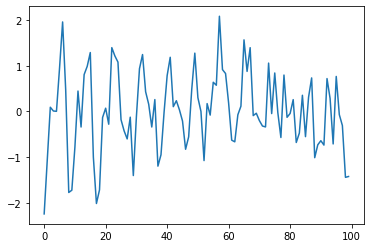

In [4]:
plt.plot(gen_x())

Now we check our intuition. To approximate the covariance structure of our vector, the next cell samples 1000 such vectors, and plots the singular values of the resulting data matrix.

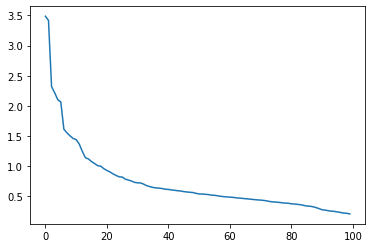

In [9]:
X = gen_x()
N = 1000
for _ in range(N-1):
    X = np.vstack((X, gen_x()))
U, Sigma, V = np.linalg.svd(X / np.sqrt(N))
plt.plot(Sigma)
    

1. **Observe the plot above. Was your initial guess about the covariance structure correct?**
2. **Substitute the TODO in the next cell with unitary matrix which will make covariance of "x_rotated" diagonal. Then run the code in the cell. Do different coordinates of "x_rotated" behave differently?** 

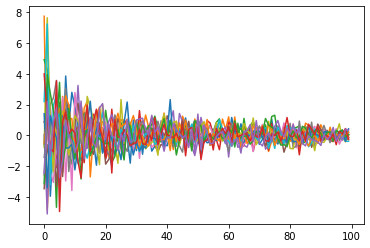

In [6]:
for _ in range(15):
    x_rotated = gen_x() @ TODO
    plt.plot(x_rotated)

### Part e

Finally, let's start working on our theoretical computation of the error. The test distribution is uniform on $[-1,1]$. Without weights, our features would be $$[1, \sin(2\pi \cdot x), \cos(2\pi\cdot x), \sin(\pi \cdot 2x), \cos(\pi \cdot 2x) \dots, \sin(\pi \cdot \lfloor d/2\rfloor x), \cos(\pi \cdot \lfloor d/2\rfloor x)].$$

Recall that those features are orthogonal w.r.t. uniform distribution on $[-1,1]$ (are they orthonormal?).

Now we use weights $\{c_i\}_{i=1}^d$. Suppose the true weights are ${\bf \theta^*}$ i.e. the true funciton is 
$$
f^*(x) = \theta_1^* c_1 + \sum_{k=1}^{\lfloor d/2\rfloor} \left(\theta_{2k-1}^*c_{2k-1}\sin(2\pi \cdot kx) + \theta_{2k}^*c_{2k}\cos(2\pi \cdot kx) \right)
$$

Suppose our learned coefficients turned out to be ${\bf \hat{\theta}}$. **Show that
$$
\mathbb{E}_{x_{\text{test}}}(f(x_{\text{test})} - \hat{f}(x_{\text{test}}))^2 = 2c_1^2 (\theta_1^* - \hat{\theta}_1)^2 + \sum_{k=2}^dc_k^2  (\theta_k^* - \hat{\theta}_k)^2.
$$
Explain how this compares to such measure of error as $\|{\bf \theta^* - \hat{\theta}}\|_2^2$.**

Now recall that in part b we saw how we compute $\hat{\theta}$ if all our features are aliases. We're going to use it here.

Suppose we use the following features:
$$[c_0\cos(\pi\cdot x), c_1\cos(\pi \cdot (2n + 1)x), c_2\cos(\pi \cdot (4n + 1)x) \dots, c_k\cos(\pi \cdot (2kn+1) x)].$$

Suppose also that our training data is $\{x_i = i/n: -n \leq i < n\}$. Let our observations be $ y_i = f(x_i)(1 + \epsilon)$, where $\epsilon$ is the noise and $f(x_i) = \cos(\pi\cdot x)$ is the true function. **Note that the noise is multiplicative here; it's just a single random variable which is the same for all the points.** We can only hope to fit such vector when all our features are aliases. In the homework you will see that the additive noise can actually be reduced to such multiplicative noise for this case.

Assume the test distribution to be uniform on $[-1,1]$. **Show that
$$
\mathbb{E}_{x_{\text{test}}}(f(x_{\text{test})} - \hat{f}(x_{\text{test}}) )^2 = c_0^2\left(\frac{c_0(1 + \epsilon)}{\sum_{m = 0}^n c_m^2} - \frac{1}{c_0}\right)^2 + \sum_{i=1}^k c_k^2\left(\frac{c_k(1 + \epsilon)}{\sum_{m = 0}^n c_m^2}\right)^2.
$$
Show also that the expectation of that error over $\epsilon$ is 
$$
\mathcal{E}_{\text{pred}}  = \left(\frac{c_0^2}{\sum_{m = 0}^n c_m^2} - 1\right)^2 + \sigma^2\left(\frac{c_0^2}{\sum_{m = 0}^n c_m^2}\right)^2 + (1 + \sigma^2)\frac{\sum_{i=1}^k c_k^4}{\left(\sum_{m = 0}^n c_m^2\right)^2}
$$
assuming that $\epsilon$ is centered and has variance $\sigma^2$. Can you see how choosing weights can help cope with the noise?**